# Demonstrate the "target-decoy" approach, as applied to metagenomic variant calling

In [1]:
%run "Header.ipynb"

In [2]:
import skbio
import pileup
from parse_sco import parse_sco

In [3]:
seq2pos2pileup = pileup.load()

## First: naive variant calling (call a position as "$p$-mutated" if $freq(pos) > p$)

We don't limit to "sufficiently-covered" positions here -- so we consider all regions throughout a genome.

In [156]:
# Percentages go from 50%, 49.99%, 49.98%, ..., 0.02%, 0.01%
percentages = [p / 100 for p in range(1, 5001, 1)][::-1]
print(f"First two percentages: {percentages[:2]}")
print(f"Last two percentages: {percentages[-2:]}")
print(f"Number of percentages: {len(percentages):,}")
p2pct = get_p2pct(percentages)

First two percentages: [50.0, 49.99]
Last two percentages: [0.02, 0.01]
Number of percentages: 5,000


In [157]:
def naive_calling(seq, positions_to_consider, verbose=True, superverbose=False):
    """seq should be in SEQS.
    
    positions_to_consider should be a collection of 1-indexed positions in the sequence to consider when
    calling mutations. This makes it possible to, for example, just consider the CP 2 positions in a sequence.
    
    Returns a tuple with three elements:
    
    1. p2called_mutations: A dict mapping values in "percentages" (defined above) to a list of 1-indexed
       "called" p-mutations in the positions to consider in the sequence, using this percentage for p.
       
    2. p2numpermb: A dict with the same keys as p2called_mutations, but the values are the number of called
       p-mutations per megabase (1,000,000 bp = 1 Mbp) in the positions to consider in this sequence.
       IT'S DEFINITELY WORTH NOTING that we scale this by the number of positions to consider, not the full
       sequence length (although it's possible that those values could be equal if positions_to_consider
       is equal to range(1, seq2len[seq] + 1)). So, if you select a subset of positions where most of them
       are mutations, this'll result in a really high number of mutations per megabase!
       ...I recognize "numpermb" doesn't really roll off the tongue, but I couldn't think
       of a better name for this :P
       
    3. poslen: Length of positions_to_consider, for reference.
    """
    poslen = len(positions_to_consider)
    seqlen = seq2len[seq]
    positions_to_consider_pct = 100 * (poslen / seqlen)
    if verbose:
        print(f"Naively calling mutations in {seq2name[seq]}.")
        print(f"\tConsidering {poslen:,} / {seqlen:,} ({positions_to_consider_pct:.2f}%) positions.")
    p2called_mutations = {p: [] for p in percentages}
    p2numpermb = {}
    for pi, pos in enumerate(sorted(positions_to_consider), 1):
        if verbose and (pi == 1 or pi % 100000 == 0):
            print(f"\tOn the {pi:,}-th position ({pos:,}) of the specified {poslen:,} positions ({100 * (pi / poslen):.2f}%).")
        pos_pileup = seq2pos2pileup[seq][pos]
        mfa_pct = pileup.get_max_freq_alt_nt_pct(pos_pileup)
        for p in percentages:
            if mfa_pct > p2pct[p]:
                p2called_mutations[p].append(pos)
                
    # We have the equation
    #
    #      # called mutations              f
    # ---------------------------- = --------------
    #  # of positions to consider     1,000,000 bp
    #
    # We know everything except for f. We can solve for f by multiplying the left side of the
    # equation by 1,000,000 bp. Since the only variable across different thresholds of p is the number
    # of called mutations, we can pre-compute this "constant length factor" (aka 1,000,000 / poslen).
    constant_length_factor = 1000000 / poslen
    for p in p2called_mutations:
        num_called_mutations = len(p2called_mutations[p])
        # solve the equation above
        f = num_called_mutations * constant_length_factor
        p2numpermb[p] = f
        # We add an extra layer of verbosity here because printing out 2 lines per value of p gets
        # ridiculous when there are 1,000 values of p .____.
        if superverbose:
            print(f"\tp = {p}%: {num_called_mutations:,} called p-mutations in {seq2name[seq]}.")
            print(f"\t\tNumber of called p-mutations per megabase: f = {f:,.2f}.")
        
    return (p2called_mutations, p2numpermb, poslen)


def naive_calling_fullseq(seq):
    """Does naive variant calling across all positions in a sequence (should be in SEQS)."""
    return naive_calling(seq, range(1, seq2len[seq] + 1))


def naive_calling_cp2seq(seq):
    """Does naive variant calling across just the CP 2 positions in a sequence (should be in SEQS).
    
    NOTE that this will filter only to positions that meet the exact criteria:
    
    - In a single gene (not in a position that is covered by overlapping genes).
    - In CP 2 within this single gene.
    
    Even if a position is in CP 2 of all the multiple genes it's covered by, we'll still ignore it.
    I'm pretty sure there should be very few positions that get tossed out as a result; my take is that
    it isn't worth the trouble to try to handle these positions.
    """
    print(f"Identifying CP 2 positions in {seq2name[seq]} so we can use them as a decoy genome...")
    cp2_positions = set()
    multi_gene_positions = set()
    
    seqlen = seq2len[seq]
    genes_df = parse_sco(f"../seqs/genes/{seq}.sco")
    
    # Code here is adapted from get_parent_gene_info_of_many_positions (in Header.ipynb) a bit
    # Faster to compute everything at once, rather than iterate through the genes multiple times
    pos_to_genes = defaultdict(list)
    
    for gene in genes_df.itertuples():
        gene_left = int(gene.LeftEnd)
        gene_right = int(gene.RightEnd)
        gene_num = int(gene.Index)
        gene_strand = gene.Strand
        
        def complainAboutCPs(gn, gs, gcp):
            raise ValueError(f"CP got out of whack: gene {gn}, strand {gs}, cp {gcp}?")
        
        if gene_strand == "+":
            cp = 1
        else:
            cp = 3
        
        for pos in range(gene_left, gene_right + 1):
            pos_to_genes[pos].append(gene_num)
            if len(pos_to_genes[pos]) > 1:
                multi_gene_positions.add(pos)
                
            if cp == 2:
                cp2_positions.add(pos)
                
            # Adjust the CP. I already have some code that does this (in a different context) in the within-
            # gene mutation spectrum notebook; ideally this code would be generalized between the notebooks.
            if gene_strand == "+":
                # For + strand genes, this goes 123123123123...
                if cp == 1 or cp == 2: cp += 1
                elif cp == 3: cp = 1
                else: complainAboutCPs(gene_num, gene_strand, cp)
            else:
                # For - strand genes, this goes 321321321321...
                if cp == 3 or cp == 2: cp -= 1
                elif cp == 1: cp = 3
                else: complainAboutCPs(gene_num, gene_strand, cp)
    
    single_gene_cp2_positions = cp2_positions - multi_gene_positions
    print(f"In {seq2name[seq]}:")
    print(f"\tThere were {len(cp2_positions):,} CP 2 positions.")
    print(f"\tThere were {len(multi_gene_positions):,} positions in multiple genes.")
    print(f"\tThere were {len(single_gene_cp2_positions):,} CP 2 positions in only a single gene.")
    return naive_calling(seq, single_gene_cp2_positions)

### Naively call mutations in CAMP and compute $\mathrm{frac}_{\mathrm{decoy}}$

(We're treating CAMP as a "decoy" genome, where we assume that all called mutations within it will be incorrect.)

In [158]:
camp_naive_p2called_mutations, camp_naive_p2numpermb, _ = naive_calling_fullseq("edge_6104")

Naively calling mutations in CAMP.
	Considering 1,289,244 / 1,289,244 (100.00%) positions.
	On the 1-th position (1) of the specified 1,289,244 positions (0.00%).
	On the 100,000-th position (100,000) of the specified 1,289,244 positions (7.76%).
	On the 200,000-th position (200,000) of the specified 1,289,244 positions (15.51%).
	On the 300,000-th position (300,000) of the specified 1,289,244 positions (23.27%).
	On the 400,000-th position (400,000) of the specified 1,289,244 positions (31.03%).
	On the 500,000-th position (500,000) of the specified 1,289,244 positions (38.78%).
	On the 600,000-th position (600,000) of the specified 1,289,244 positions (46.54%).
	On the 700,000-th position (700,000) of the specified 1,289,244 positions (54.30%).
	On the 800,000-th position (800,000) of the specified 1,289,244 positions (62.05%).
	On the 900,000-th position (900,000) of the specified 1,289,244 positions (69.81%).
	On the 1,000,000-th position (1,000,000) of the specified 1,289,244 posi

In [159]:
camp_cp2_naive_p2called_mutations, camp_cp2_naive_p2numpermb, num_camp_cp2_pos = naive_calling_cp2seq("edge_6104")

Identifying CP 2 positions in CAMP so we can use them as a decoy genome...
In CAMP:
	There were 397,489 CP 2 positions.
	There were 4,101 positions in multiple genes.
	There were 394,879 CP 2 positions in only a single gene.
Naively calling mutations in CAMP.
	Considering 394,879 / 1,289,244 (30.63%) positions.
	On the 1-th position (267) of the specified 394,879 positions (0.00%).
	On the 100,000-th position (325,447) of the specified 394,879 positions (25.32%).
	On the 200,000-th position (651,427) of the specified 394,879 positions (50.65%).
	On the 300,000-th position (977,868) of the specified 394,879 positions (75.97%).


### For comparison, naively call mutations in BACT1 and compute $\mathrm{frac}_{\mathrm{BACT1}}$

In [160]:
bact1_naive_p2called_mutations, bact1_naive_p2numpermb, _ = naive_calling_fullseq("edge_1671")

Naively calling mutations in BACT1.
	Considering 2,153,394 / 2,153,394 (100.00%) positions.
	On the 1-th position (1) of the specified 2,153,394 positions (0.00%).
	On the 100,000-th position (100,000) of the specified 2,153,394 positions (4.64%).
	On the 200,000-th position (200,000) of the specified 2,153,394 positions (9.29%).
	On the 300,000-th position (300,000) of the specified 2,153,394 positions (13.93%).
	On the 400,000-th position (400,000) of the specified 2,153,394 positions (18.58%).
	On the 500,000-th position (500,000) of the specified 2,153,394 positions (23.22%).
	On the 600,000-th position (600,000) of the specified 2,153,394 positions (27.86%).
	On the 700,000-th position (700,000) of the specified 2,153,394 positions (32.51%).
	On the 800,000-th position (800,000) of the specified 2,153,394 positions (37.15%).
	On the 900,000-th position (900,000) of the specified 2,153,394 positions (41.79%).
	On the 1,000,000-th position (1,000,000) of the specified 2,153,394 posi

### Just so we can update the `misc-text/` file, also do this for  BACT2

probs possible to get this info from another notebook but this is the easiest way to handle this imo

In [161]:
bact2_naive_p2called_mutations, bact2_naive_p2numpermb, _ = naive_calling_fullseq("edge_2358")

Naively calling mutations in BACT2.
	Considering 2,806,161 / 2,806,161 (100.00%) positions.
	On the 1-th position (1) of the specified 2,806,161 positions (0.00%).
	On the 100,000-th position (100,000) of the specified 2,806,161 positions (3.56%).
	On the 200,000-th position (200,000) of the specified 2,806,161 positions (7.13%).
	On the 300,000-th position (300,000) of the specified 2,806,161 positions (10.69%).
	On the 400,000-th position (400,000) of the specified 2,806,161 positions (14.25%).
	On the 500,000-th position (500,000) of the specified 2,806,161 positions (17.82%).
	On the 600,000-th position (600,000) of the specified 2,806,161 positions (21.38%).
	On the 700,000-th position (700,000) of the specified 2,806,161 positions (24.95%).
	On the 800,000-th position (800,000) of the specified 2,806,161 positions (28.51%).
	On the 900,000-th position (900,000) of the specified 2,806,161 positions (32.07%).
	On the 1,000,000-th position (1,000,000) of the specified 2,806,161 posi

### Output info about FDR estimation for $p=0.5\%$ to `misc-text/`

In [162]:
# Total numbers of identified p-mutations
camp_nump = len(camp_naive_p2called_mutations[0.5])
bact1_nump = len(bact1_naive_p2called_mutations[0.5])
bact2_nump = len(bact2_naive_p2called_mutations[0.5])
# Scaled numbers of identified p-mutations per megabase (comparable across different-length genomes
# [at least, if you assume that genome length is the only confounding factor here, which it isn't -- we
# should mention this in the paper ofc])
camp_numpermb = camp_naive_p2numpermb[0.5]
bact1_numpermb = bact1_naive_p2numpermb[0.5]
bact2_numpermb = bact2_naive_p2numpermb[0.5]

bact1_fdr = camp_numpermb / bact1_numpermb

naiveinfo = (
    f"At $p=0.5$\\%, we identified {camp_nump:,}, {bact1_nump:,}, and {bact2_nump:,} $p$-mutations "
    f"in the {seq2name['edge_6104']}, {seq2name['edge_1671']}, and {seq2name['edge_2358']} genomes, "
    f"respectively. This illustrates that there exists a difference of nearly two orders of magnitude "
    f"in the number of $p$-mutations per megabase across these genomes "
    f"({round(camp_numpermb):,}, {round(bact1_numpermb):,}, and {round(bact2_numpermb):,} for "
    f"{seq2name['edge_6104']}, {seq2name['edge_1671']}, and {seq2name['edge_2358']}, respectively and "
    f"after rounding). If the {seq2name['edge_6104']} genome, which has a relatively low mutation rate, is "
    f"selected as a decoy, then we estimate the FDR for the {seq2name['edge_1671']} genome at $p=0.5\\%$ as "
    "$\\frac{" + f"{camp_numpermb:,.2f}" + "}" + "{" + f"{bact1_numpermb:,.2f}" + "}" + f" \\approx {bact1_fdr:.4f}$."
)
with open("misc-text/naive-calling-target-decoy.tex", "w") as of:
    # see https://tex.stackexchange.com/a/18018
    of.write("{}\endinput".format(naiveinfo))

## Plot estimated BACT1 FDR vs. scaled number of identified mutations

Previous versions of this notebook only drew one FDR curve at a time; now, this function accepts multiple decoy genome `p2numpermb` objects.

In [260]:
def plot_bact1_fdr(
    decoy_p2numpermbs, colors, shapes, decoy_labels, fig_basename,
    use_log=True, start_p=None, end_p=None, show_p_labels=False,
    special_p_markers=[50, 25, 13, 10, 5, 2, 0.22, 0.15, 0.13, 0.08, 0.06, 0.01]
):
    """decoy_p2numpermbs, colors, shapes, and decoy_labels should all be collections of identical length
    (this lets you pass in and style multiple decoy genomes to be shown on the same plot).
    """
    
    fig, ax = pyplot.subplots(1)
    
    for di, decoy_p2numpermb in enumerate(decoy_p2numpermbs):
        if start_p is None:
            start_p = percentages[0]
        
        if end_p is None:
            end_p = percentages[-1]
        
        used_percentages = percentages[percentages.index(start_p) : percentages.index(end_p) + 1]
        
        p2bact1fdr = {p: decoy_p2numpermb[p] / bact1_naive_p2numpermb[p] for p in used_percentages}

        # FDR
        x = []
        # number of mutations per megabase
        y = []
        # list of 2-tuples of (x,y). we'll highlight these points.
        special_xys = []
        for p in used_percentages:
            cx = p2bact1fdr[p]
            cy = bact1_naive_p2numpermb[p]
            x.append(cx)
            y.append(cy)
            if show_p_labels:
                # add labels (manually positioned). yeah, i know i know
                # we only show these labels once per plot (to avoid the text overlapping itself
                # from doing this multiple times), and we don't do this for non-log plots since
                # i tuned the adjusted coordinates to log plots
                dy = None
                dx = None
                if use_log:
                    if p == 50: dy = -20; dx = -0.01
                    elif p == 25: dy = 20; dx = -0.09
                    elif p == 13: dy = -5; dx = 0.02
                    elif p == 10: dy = 10; dx = 0.03
                    elif p == 5: dy = -100; dx = 0.03
                    elif p == 2: dy = -10**3; dx = 0.03
                    elif p == 0.22: dy = -10**3.3; dx = 0.03
                    elif p == 0.15: dy = -10**3; dx = 0.03
                    elif p == 0.13: dy = 15000; dx = -0.1
                    elif p == 0.08: dy = 0; dx=0.03
                    elif p == 0.06: dy = 53000; dx = -0.04
                    elif p == 0.01: dy = 53000; dx = -0.05
                else:
                    if p == 2: dy = -10**3.7; dx = 0.03
                    elif p == 0.22: dy = -10**3.9; dx = 0.03
                    elif p == 0.15: dy = -10**3; dx = 0.03
                    elif p == 0.13: dy = 10000; dx = -0.1
                    elif p == 0.08: dy = 0; dx=0.03
                    elif p == 0.06: dy = 5000; dx = -0.04
                    elif p == 0.01: dy = 5000; dx = -0.05
                    
                if dy is not None:
                    if p >= 1:
                        text = f"$p = {p:.0f}\%$"
                    elif p >= 0.5:
                        text = f"$p = {p:.1f}\%$"
                    else:
                        text = f"$p = {p:.2f}\%$"
                    if di == 0:
                        ax.text(cx + dx, cy + dy, text)
                        
            if p in special_p_markers:
                special_xys.append((cx, cy))

        ax.plot(x, y, marker=shapes[di], color=colors[di], label=decoy_labels[di])
        if len(special_xys) > 0:
            ax.scatter([xy[0] for xy in special_xys], [xy[1] for xy in special_xys], color="#ffff00", zorder=2000, s=20)
        
    ax.set_xlabel(f"Estimated FDR for called $p$-mutations in {seq2name['edge_1671']}")
    ax.set_ylabel("Number of called $p$-mutations per megabase")
    title = (
        f"{seq2name['edge_1671']} FDR curves, using {len(used_percentages):,} values of $p$ from {max(used_percentages):.0f}% to {min(used_percentages):.2f}%"
    )
    if use_log:
        ax.set_yscale("symlog")
        title += " (log scale)"
    else:
        title += " (non-log scale)"
    ax.set_title(title, fontsize=20)
    ax.legend()
    use_thousands_sep(ax.yaxis)
    fig.set_size_inches(15, 8)
    fig.savefig(f"figs/{fig_basename}.png", bbox_inches="tight")

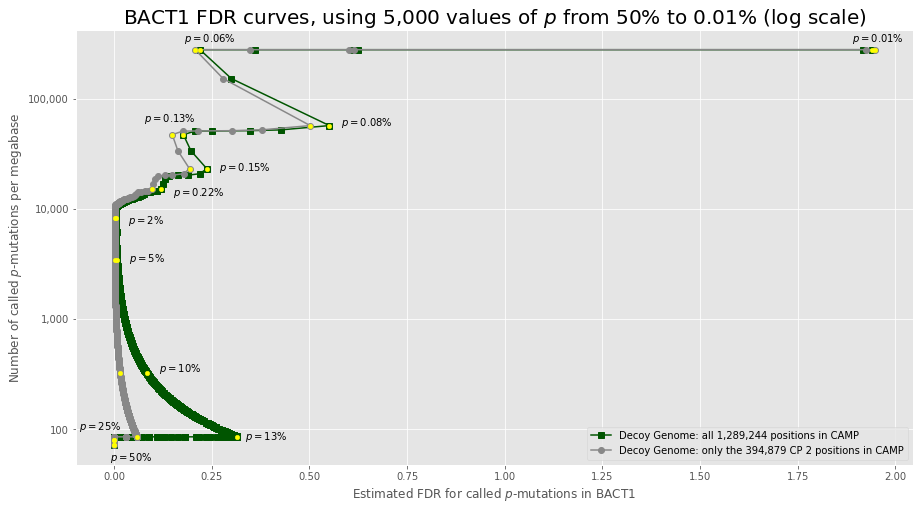

In [258]:
plot_bact1_fdr(
    (camp_naive_p2numpermb, camp_cp2_naive_p2numpermb),
    ("#005500", cp2color[2]),
    ("s", "o"),
    (
        f"Decoy Genome: all {seq2len['edge_6104']:,} positions in {seq2name['edge_6104']}",
        f"Decoy Genome: only the {num_camp_cp2_pos:,} CP 2 positions in {seq2name['edge_6104']}",
    ),
    "BACT1_FDR_CAMP_decoy",
    show_p_labels=True
)

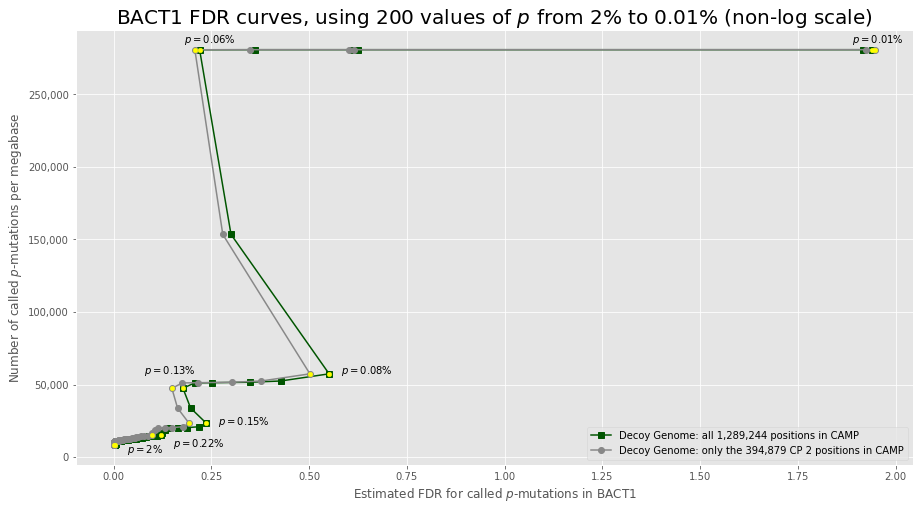

In [261]:
# plot_bact1_fdr(
#     (camp_naive_p2numpermb, camp_cp2_naive_p2numpermb),
#     ("#005500", cp2color[2]),
#     ("s", "o"),
#     (
#         f"Decoy Genome: all {seq2len['edge_6104']:,} positions in {seq2name['edge_6104']}",
#         f"Decoy Genome: only the {num_camp_cp2_pos:,} CP 2 positions in {seq2name['edge_6104']}",
#     ),
#     "BACT1_FDR_CAMP_decoy_max2",
#     start_p=2
# )
plot_bact1_fdr(
    (camp_naive_p2numpermb, camp_cp2_naive_p2numpermb),
    ("#005500", cp2color[2]),
    ("s", "o"),
    (
        f"Decoy Genome: all {seq2len['edge_6104']:,} positions in {seq2name['edge_6104']}",
        f"Decoy Genome: only the {num_camp_cp2_pos:,} CP 2 positions in {seq2name['edge_6104']}",
    ),
    "BACT1_FDR_CAMP_decoy_nonlog_max2",
    use_log=False,
    start_p=2,
    show_p_labels=True
)